In [1]:
# Standard imports
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import re
import sklearn
import matplotlib.pyplot as plt

# Model evaluation functions
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve

## 1. Acquire the data

Dataset is available at: https://datarepository.wolframcloud.com/resources/Patient-Medical-Data-for-Novel-Coronavirus-COVID-19

Read data from csv file and also replace all 'Missing["NotAvailable"]' values with NaN

In [2]:
dataset_path = 'Patient-Medical-Data-for-Novel-Coronavirus-COVID-19_updated.csv' # Replace this as necessary

def load_data():
    data = pd.read_csv(dataset_path)
    data.replace('Missing["NotAvailable"]', np.NaN, inplace=True)
    return data

data = load_data()

In [3]:
# Data preview
data.head()

,Age,Sex,City,AdministrativeDivision,Country,GeoPosition,DateOfOnsetSymptoms,DateOfAdmissionHospital,DateOfConfirmation,Symptoms,...,TravelHistoryLocation,ReportedMarketExposure,ReportedMarketExposureComment,ChronicDiseaseQ,ChronicDiseases,SequenceAvailable,DischargedQ,DeathQ,DateOfDeath,DateOfDischarge
0,48,"Entity[""Gender"", ""Female""]","Entity[""City"", {""Wuhan"", ""Hubei"", ""China""}]","Entity[""AdministrativeDivision"", {""Hubei"", ""Ch...","Entity[""Country"", ""China""]","GeoPosition[{30.625059999999998, 114.3421}]","DateObject[{2019, 12, 10}, ""Day"", ""Gregorian"",...","DateObject[{2019, 12, 10}, ""Day"", ""Gregorian"",...",NaN,"{""cough"", ""fatigue"", ""fever"", ""sputum"", ""myalg...",...,NaN,NaN,NaN,True,"{""diabetes"", ""cerebral infarction""}",NaN,NaN,True,"DateObject[{2020, 1, 20}, ""Day"", ""Gregorian"", ...",NaN
1,"Interval[{15, 88}]","Entity[""Gender"", ""Female""]","Entity[""City"", {""Wuhan"", ""Hubei"", ""China""}]","Entity[""AdministrativeDivision"", {""Hubei"", ""Ch...","Entity[""Country"", ""China""]","GeoPosition[{30.625059999999998, 114.3421}]","DateObject[{2019, 12, 10}, ""Day"", ""Gregorian"",...","DateObject[{2019, 12, 31}, ""Day"", ""Gregorian"",...",NaN,"{""shortness of breath"", ""respiratory symptoms""}",...,NaN,NaN,NaN,False,NaN,NaN,NaN,True,NaN,NaN
2,61,"Entity[""Gender"", ""Male""]","Entity[""City"", {""Wuhan"", ""Hubei"", ""China""}]","Entity[""AdministrativeDivision"", {""Hubei"", ""Ch...","Entity[""Country"", ""China""]","GeoPosition[{30.625059999999998, 114.3421}]","DateObject[{2019, 12, 20}, ""Day"", ""Gregorian"",...","DateObject[{2019, 12, 27}, ""Day"", ""Gregorian"",...",NaN,NaN,...,NaN,NaN,NaN,False,NaN,True,NaN,True,"DateObject[{2020, 1, 9}, ""Day"", ""Gregorian"", -5.]",NaN
3,58,"Entity[""Gender"", ""Male""]","Entity[""City"", {""Wuhan"", ""Hubei"", ""China""}]","Entity[""AdministrativeDivision"", {""Hubei"", ""Ch...","Entity[""Country"", ""China""]","GeoPosition[{30.625059999999998, 114.3421}]","DateObject[{2019, 12, 22}, ""Day"", ""Gregorian"",...","DateObject[{2020, 1, 1}, ""Day"", ""Gregorian"", -5.]",NaN,"{""cough"", ""sputum"", ""fever""}",...,NaN,NaN,NaN,False,NaN,NaN,NaN,True,"DateObject[{2020, 1, 23}, ""Day"", ""Gregorian"", ...",NaN
4,66,"Entity[""Gender"", ""Male""]","Entity[""City"", {""Wuhan"", ""Hubei"", ""China""}]","Entity[""AdministrativeDivision"", {""Hubei"", ""Ch...","Entity[""Country"", ""China""]","GeoPosition[{30.625059999999998, 114.3421}]","DateObject[{2019, 12, 22}, ""Day"", ""Gregorian"",...","DateObject[{2019, 12, 31}, ""Day"", ""Gregorian"",...",NaN,"{""cough""}",...,NaN,NaN,NaN,False,NaN,NaN,NaN,True,"DateObject[{2020, 1, 21}, ""Day"", ""Gregorian"", ...",NaN


## 2. Clean the data

### 2.1. First look

For each column, compute percentage of missing values

In [4]:
data.isna().sum() * 100 / len(data)

Age                               14.751684
Sex                               14.498457
City                              48.201810
AdministrativeDivision            29.374299
Country                            0.016835
GeoPosition                        0.000000
DateOfOnsetSymptoms               42.209947
DateOfAdmissionHospital           85.909442
DateOfConfirmation                13.424874
Symptoms                          99.374649
LivesInWuhan                      99.364478
LivesInWuhanComment              100.000000
TravelHistoryDates                99.132295
TravelHistoryLocation             97.404251
ReportedMarketExposure            99.973345
ReportedMarketExposureComment     99.994739
ChronicDiseaseQ                    0.000000
ChronicDiseases                   99.947391
SequenceAvailable                 99.997896
DischargedQ                       99.958965
DeathQ                            99.946338
DateOfDeath                       99.948092
DateOfDischarge                 

A short comment on each feature at first glance:
- **Age** should play an important role in deciding wether the patient survives or not so it should be taken into account
- **Sex** &ndash; the same is true about gender because the disease is more prevalent in men
- **GeoPosition** is expressed by latitude and longitude. There are also no values missing in this column, so it should definitely be included in the final dataset. Furthermore, this feature may render other location features redundant as well
- **City**, **AdministrativeDivision**, **Country**, **LivesInWuhan**, **LivesInWuhanComment** &ndash; let's try to ignore these ones at first, based on above comment on GeoPosition rendering them redundant
- **DateOfOnsetSymptoms**, **DateOfAdmissionHospital**, **DateOfConfirmation** &ndash; correctly filling in missing values for these features looks complicated, so we'll ignore them for now
- **Symptoms** should offer plenty of information
- **TravelHistoryDates**, **TravelHistoryLocation** &ndash; only take into account locations, ignore dates
- **ReportedMarketExposure**, **ReportedMarketExposureComment** don't seem to hold alot of information; drop them from the analysis
- **ChronicDiseaseQ**, **ChronicDiseases** should be taken into account
- **SequenceAvailable**, **DischargedQ**, **DateOfDeath**, **DateOfDeath** look pretty irrelevant
- **DeathQ** &ndash; this is the prediction target column

### 2.2. Define functions for each particular column to be processed

Age values are either a number, an interval (stored as: *Interval[(Age1, Age2)]*), or missing

```process_age_value``` uses regex to extract age information from a given age value by trying to match numbers
- if 2 numbers are matched, age value is stored as an interval, so return mean of those values
- otherwise, return the number matched

```process_age_column``` applies above function to each age value then fills missing values with mean of values that are present

In [5]:
def process_age_value(age_value):
    if not pd.isna(age_value):
        m = re.findall(r'([0-9]+)', age_value)
        if len(m) == 2:
            return (int(m[0]) + int(m[1]))/2
        else:
            return int(m[0])

def process_age_column(age):
    age = age.apply(lambda x : process_age_value(x))
    return age.astype(np.float64).fillna(age.mean())

Sex values are either *Entity["Gender", "Male"]*, *Entity["Gender", "Female"]* or missing

```process_sex_value``` returns ```'Male'``` or ```'Female'``` based on the sex value given as parameter

```process_sex_column``` applies above function to each sex column then fills missing values by following these steps:
- computes sex distribution of existent values
- fills missing values with a random variable whose distribution is equal to above computed distribution

In [6]:
def process_sex_value(sex_value):
    if 'Female' in sex_value:
        return 'Female'
    else:
        return 'Male'

def process_sex_column(sex):
    sex = sex.fillna("").apply(lambda x : process_sex_value(x))
    sex_distribution = sex.value_counts(normalize=True)
    missing_values = sex.isna()
    sex[missing_values] = np.random.choice(['Male', 'Female'],
                                           size=len(sex[missing_values]),
                                           p=[sex_distribution['Male'], sex_distribution['Female']])
    
    return sex.apply(lambda x : 1 if x == 'Female' else 0)

```process_geo_pos_value``` extracts latitude and longitude from given ```geo_pos_value``` and returns them as a tuple

```process_geo_pos_column``` calls above function and returns two new columns corresponding to latitude and longitude

In [7]:
def process_geo_pos_value(geo_pos_value):    
    m = re.findall(r'(-?[0-9]+\.[0-9]*)', geo_pos_value)
    if len(m) == 2:            
        return float(m[0]), float(m[1])
    else:
        return 0.0, 0.0
def process_geo_pos_column(geo_pos):
    # Split column in 2 columns corresponding
    # to latitude and longitude
    d = pd.Series(geo_pos.fillna("").apply(lambda x : process_geo_pos_value(x)).values)
    to_return = pd.DataFrame()
    to_return['Lat'] = d.apply(lambda x : x[0])
    to_return['Long'] = d.apply(lambda x : x[1])
    return to_return
    

```get_unique_symptoms``` returns a ```set``` object containing all unique symptoms in column given as parameter

```process_symptoms_column``` calls above function and returns a data frame containing a one-hot encoding of all symptoms in the Symptoms column

In [8]:
import ast

def get_unique_symptoms(symptoms):
    n = symptoms.shape[0] # nr randuri
    s = set() # empty set    
    for i in range(n):
        if not pd.isna(symptoms[i]):
            try:
                s = s.union(ast.literal_eval(symptoms[i]))
            except:
                ...                
                
    return s

def process_symptoms_column(symptoms_col):
    # Get unique symptoms from dataset
    unique_symptoms = get_unique_symptoms(symptoms_col)
    
    to_return = pd.DataFrame()
    for symptom in unique_symptoms:
        to_return[f'symptom_{symptom}'] = symptoms_col.fillna("").apply(lambda x : 1 if symptom in x else 0)
        
    return to_return
    

In [9]:
# Should be included into model in the future

# def get_temp_value(symptoms_val):
#     m = re.findall(r'([0-9]+\.*[0-9]*)', symptoms_val)
#     if len(m) == 2:
#         # Treating values that contain an interval for temperature
#         return (float(m[0]) + float(m[1])) / 2
#     elif len(m) == 1:
#         # Simple case when only one temperature value appears
#         return float(m[0])
#     else:
#         return 0.0
#     
# 
# def create_temp_column(symptoms_col):
#     to_return = pd.DataFrame()
#     to_return['temp'] = symptoms_col.fillna("").apply(lambda x : get_temp_value(x))
#     
#     return to_return
#     

Similarily to symptoms, get the one-hot encoding of chronic diseases

In [10]:
import ast

def get_unique_chronic_diseases(chronic_diseases_col):
    n = chronic_diseases_col.shape[0] # nr randuri
    s = set() # empty set    
    for i in range(n):
        if not pd.isna(chronic_diseases_col[i]):
            try:
                s = s.union(ast.literal_eval(chronic_diseases_col[i]))
            except:
                ...                
                
    return s

def process_chronic_diseases_column(chronic_diseases_col):
    # Get unique diseases from dataset
    unique_diseases = get_unique_chronic_diseases(chronic_diseases_col)
    
    to_return = pd.DataFrame()
    for disease in unique_diseases:
        to_return[f'disease_{disease}'] = chronic_diseases_col.fillna("").apply(lambda x : 1 if disease in x else 0)
        
    return to_return
    

 and travel history locations

In [11]:
def get_unique_locations(travel_his_col):    
    travel_history_list = travel_his_col.fillna("").apply(lambda x : re.findall(r'Entity\[[^\]\[]+\]', x))
    unique_locations = np.unique(np.concatenate(travel_history_list))
    return unique_locations

def process_travel_history_column(travel_his_col):
    unique_locations = get_unique_locations(travel_his_col)
    to_return = pd.DataFrame()
    for location in unique_locations:
        to_return[f'travelled_to_{location}'] = travel_his_col.fillna("").apply(lambda x : 1 if location in x else 0)
    return to_return

Create a class that inherits from ```BaseEstimator``` and ```TransformerMixin``` and whose ```transform``` method calls all transformation functions defined above in order to clean the dataset.

This enables the class to be used in sklearn transformation pipelines, in case some other transformations are required before or after feature clean-up.

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        ...
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None, standard_scaling=True):
        # Process age column
        X['Age'] = process_age_column(X['Age'])
        # Process sex column
        X['Sex'] = process_sex_column(X['Sex'])
        
        # Get latitude and longitude columns column
        # and drop GeoPosition column
        geo_pos = process_geo_pos_column(X['GeoPosition'])
        X.drop(['GeoPosition'], axis=1, inplace=True)
        # Get one-hot encoded symptoms
        # and drop Symptoms column
        symptoms = process_symptoms_column(X['Symptoms'])
        X.drop(['Symptoms'], axis=1, inplace=True)
        # Get one-hot encoded chronic diseases
        # and drop ChronicDiseases column
        chronic_diseases = process_chronic_diseases_column(X['ChronicDiseases'])
        X.drop(['ChronicDiseases'], axis=1, inplace=True)
        # Get one-hot encoded travel history values
        # and drop TravelHistoryLocation column
        travel_his = process_travel_history_column(X['TravelHistoryLocation'])
        X.drop(['TravelHistoryLocation'], axis=1, inplace=True)
        
        # Change values in ChronicDiseaseQ column from True and False to 1 and 0
        X['ChronicDiseaseQ'] = X['ChronicDiseaseQ'].apply(lambda x : 1 if x == 'True' else 0)
        
        # Concatenate all four above datasets into the source dataset
        X = pd.concat([X, geo_pos, symptoms, chronic_diseases, travel_his], axis=1)
        
        # Drop irrelevant columns
        irrelevant_columns = ['City', 'AdministrativeDivision', 'Country', 'DateOfOnsetSymptoms', 'DateOfAdmissionHospital',
                               'DateOfConfirmation', 'LivesInWuhan', 'LivesInWuhanComment', 'TravelHistoryDates', 'ReportedMarketExposure',
                               'ReportedMarketExposureComment', 'SequenceAvailable', 'DischargedQ', 'DateOfDeath', 'DateOfDischarge']
        X.drop(irrelevant_columns, axis=1, inplace=True)        
        
        # Return clean dataset
        return X

## 3. Prepare data for training and testing

Clean up feature columns and extract the target column

In [13]:
data_cleaner = DataCleaner()

X = data_cleaner.transform(data.drop(['DeathQ'], axis=1))
# Replace each of currence of True with 1 and insert 0 where data is missing
y = data['DeathQ'].fillna("").apply(lambda x : 1 if x == 'True' else 0)

Split dataset into train and test data

In [14]:
from sklearn.model_selection import train_test_split

# Use 33% of data for testing and the rest for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 4. Select a model and train it

We'll choose a simple model &ndash; a logistic regression classifier

In [15]:
from sklearn.linear_model import LogisticRegression

# Use standard hyperparameters and liblinear as solver
log_reg = LogisticRegression(verbose=1, solver='liblinear')
log_reg.fit(X_train, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

## 5. Evaluate model performance

In [16]:
accuracy = accuracy_score(y_test, log_reg.predict(X_test))
print(f'Model accuracy: {accuracy * 100:.2f}%')

Model accuracy: 99.97%


This extremely high accuracy score value is to be expected (and is, in fact, a paradox) because the dataset is heavily unbalanced. Let's have a look.

In [17]:
deathq_distribution = y_train.value_counts(normalize=True)
print(deathq_distribution)

0    0.999445
1    0.000555
Name: DeathQ, dtype: float64


Almost 99.95% of samples belong to the class 0, meaning they are pacients who survived COVID. In this case, even a trivial "machine learning" model that always predicts 0 would be right in 99.95% of cases!

Let's try to use other evaluation metrics, such as recall and precision. A low recall score means that our model predicts 0 (that is *survived*) for patients who, unfortunately, have died. That would be really bad. A low precision score means that our model predicts 1 for patients who have survived. That wouldn't be good either.

In [18]:
recall = recall_score(y_test, log_reg.predict(X_test))
print(f'Model recall: {recall:.4f}')
precision = precision_score(y_test, log_reg.predict(X_test))
print(f'Model precision: {precision:.4f}')

Model recall: 0.4043
Model precision: 0.9500


As expected, our model performs badly in terms of recall because of how unbalanced the dataset is, but we will try to improve that.

## 6. Improve model performance

### 6.1. Standardize the data

Let's start by standardizing the values in Age, Lat, and Long columns, because Logistic Regression benefits from dealing with standardized data.

In [19]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
X_train[['Age', 'Lat', 'Long']] = standard_scaler.fit_transform(X_train[['Age', 'Lat', 'Long']])
X_test[['Age', 'Lat', 'Long']] = standard_scaler.transform(X_test[['Age', 'Lat', 'Long']])

Re-train the model using standardized data

In [20]:
log_reg_std = LogisticRegression(verbose=1, solver='liblinear')
log_reg_std.fit(X_train, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

Re-evaluate the model

In [21]:
accuracy = accuracy_score(y_test, log_reg_std.predict(X_test))
print(f'Model accuracy: {accuracy * 100:.2f}%')
recall = recall_score(y_test, log_reg_std.predict(X_test))
print(f'Model recall: {recall:.4f}')
precision = precision_score(y_test, log_reg_std.predict(X_test))
print(f'Model precision: {precision:.4f}')

Model accuracy: 99.97%
Model recall: 0.4468
Model precision: 0.9545


No loss of accuracy, but a slight gain in recall. Still not enough.

### 6.2 Use class weights

An idea in the case of unbalanced datasets is to use class weights in training and assign more weight to the scarce class.

Let's try some initial values and assign a weight of 0.1 to patients who survived, and a weight of 0.9 to those who didn't. By doing this, our model treats samples of class 1 (not survived) as 9 times more important than those from class 0.

In [22]:
class_weights = {0 : 0.1, 1 : 0.9}

Re-train the model using class weights

In [23]:
log_reg_weighted = LogisticRegression(class_weight=class_weights, verbose=1, solver='liblinear')
log_reg_weighted.fit(X_train, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight={0: 0.1, 1: 0.9}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

Re-evaluate the model

In [24]:
accuracy = accuracy_score(y_test, log_reg_weighted.predict(X_test))
print(f'Model accuracy: {accuracy * 100:.2f}%')
recall = recall_score(y_test, log_reg_weighted.predict(X_test))
print(f'Model recall: {recall:.4f}')
precision = precision_score(y_test, log_reg_weighted.predict(X_test))
print(f'Model precision: {precision:.4f}')

Model accuracy: 99.96%
Model recall: 0.5745
Model precision: 0.6429


This looks like the right path for increasing recall. But we should be aware of the fact that precision is dropping as recall is increasing.

Let's try to visualize how the model performs with different class weights that are close to the above values. Train the model using different weights and store evaluation results in arrays.

In [25]:
recall_scores = []
precision_scores = []
weights = []
weight_class_0 = 0.1

for _ in range(10):
    model = LogisticRegression(class_weight={0: weight_class_0, 1: 1 - weight_class_0}, solver='liblinear')
    model.fit(X_train, y_train)
    recall_scores.append(recall_score(y_test, model.predict(X_test)))
    precision_scores.append(precision_score(y_test, model.predict(X_test)))
    weights.append(1 - weight_class_0)
    weight_class_0 -= 0.01

Plot results

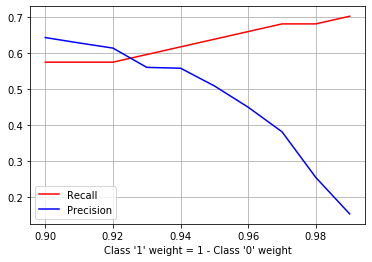

In [26]:
plt.plot(weights, recall_scores, color='r', label='Recall')
plt.plot(weights, precision_scores, color='b', label='Precision')
plt.legend()
plt.xlabel('Class \'1\' weight = 1 - Class \'0\' weight')
plt.grid()
plt.show()

Looks like precision is decreasing significantly as the weight for class '1' increases.

Let's visualize which features play the most important role in making a decision

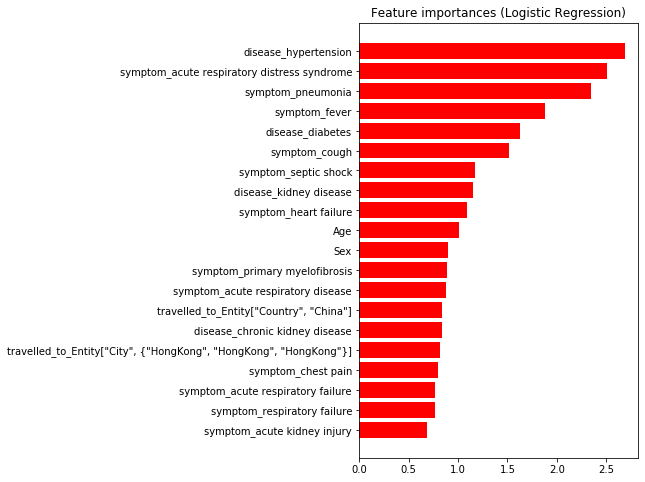

In [27]:
coefs = np.abs(log_reg_weighted.coef_[0])
indices = np.argsort(coefs)[::-1]

n = 20 # 20 most important features

plt.figure(figsize=(5,8))
plt.title("Feature importances (Logistic Regression)")
plt.barh(range(n), coefs[indices[:n]][::-1],
       color="r", align="center")
plt.yticks(range(n), X_train.columns[indices[:n]][::-1], ha='right')
plt.show()

## 7. Trying other models

Let's check how other classifiers perform in this task.

### 7.1. Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [29]:
accuracy = accuracy_score(y_test, tree.predict(X_test))
print(f'Model accuracy: {accuracy * 100:.2f}%')
recall = recall_score(y_test, tree.predict(X_test))
print(f'Model recall: {recall:.4f}')
precision = precision_score(y_test, tree.predict(X_test))
print(f'Model precision: {precision:.4f}')

Model accuracy: 99.97%
Model recall: 0.6383
Model precision: 0.7143


Not bad! But it could certainly use some improvement. Let's see how the model behaves when varying some parameters, such as the ```min_samples_split```, which represents 'the minimum number of samples required to split an internal node'.

In [30]:
recall_scores = []
precision_scores = []
min_sample_splits = []
min_sample_split_val = 8

for _ in range(5):
    model = DecisionTreeClassifier(min_samples_split=min_sample_split_val)
    model.fit(X_train, y_train)
    recall_scores.append(recall_score(y_test, model.predict(X_test)))
    precision_scores.append(precision_score(y_test, model.predict(X_test)))
    min_sample_splits.append(min_sample_split_val)
    min_sample_split_val += 2

from sklearn.tree import DecisionTreeClassifier

Plot results

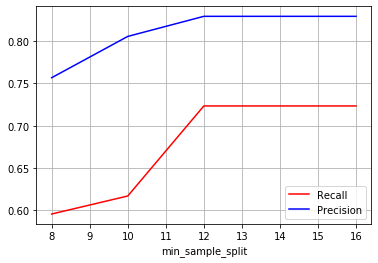

In [31]:
plt.plot(min_sample_splits, recall_scores, color='r', label='Recall')
plt.plot(min_sample_splits, precision_scores, color='b', label='Precision')
plt.legend()
plt.xlabel('min_sample_split')
plt.grid()
plt.show()

When ```min_sample_split``` is 12, the model has a recall score of ~0.725 and a precision above 0.8, which is better than all previous results.

### 7.2. Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

c:\programdata\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [33]:
accuracy = accuracy_score(y_test, rfc.predict(X_test))
print(f'Model accuracy: {accuracy * 100:.2f}%')
recall = recall_score(y_test, rfc.predict(X_test))
print(f'Model recall: {recall:.4f}')
precision = precision_score(y_test, rfc.predict(X_test))
print(f'Model precision: {precision:.4f}')

Model accuracy: 99.98%
Model recall: 0.6383
Model precision: 0.8333


A RandomForestClassifier with default hyperparameters performs similarly to the decision tree with ```min_samples_split = 12```

In [34]:
from sklearn.ensemble import RandomForestClassifier

rfc2 = RandomForestClassifier(n_estimators=250)
rfc2.fit(X_train, y_train)

accuracy = accuracy_score(y_test, rfc2.predict(X_test))
print(f'Model accuracy: {accuracy * 100:.2f}%')
recall = recall_score(y_test, rfc2.predict(X_test))
print(f'Model recall: {recall:.4f}')
precision = precision_score(y_test, rfc2.predict(X_test))
print(f'Model precision: {precision:.4f}')

Model accuracy: 99.98%
Model recall: 0.7660
Model precision: 0.8780


Increasing the number of decision trees in the forest by modifying the ```n_estimators``` parameter yields to even better results. A GridSearch could be computed to find the best parameters.

Let's visualize what features does the RandomForestClassifier regard as important.

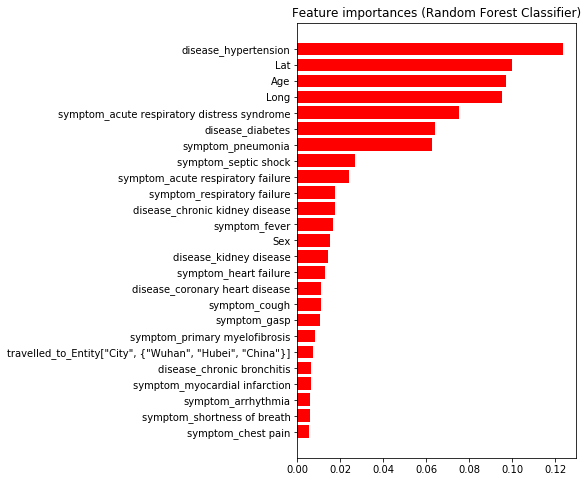

In [35]:
coefs = rfc2.feature_importances_
indices = np.argsort(coefs)[::-1]

n = 25 # 25 most important features

plt.figure(figsize=(5,8))
plt.title("Feature importances (Random Forest Classifier)")
plt.barh(range(n), coefs[indices[:n]][::-1],
       color="r", align="center")
plt.yticks(range(n), X_train.columns[indices[:n]][::-1], ha='right')
plt.show()

## 8. Conclusion

The dataset for this learning task is heavily unbalanced and simple models such as the LogReg classifier do not yield the best results. However, by using an ensemble learning method, like the RandomTreeClassifier, higher evaluation scores are obtained. The problem of class unbalance in data could be solved by resorting to other approaches too, such as undersampling or oversampling, which should be targets for future improvement of this project.